<h1>Preprocessing Script</h1>

<h3> Task 1: Convert the random sized images into standard size</h3>


Import these modules for the preprocessing of the data

In [1]:
import PIL 
from PIL import Image
from __future__ import print_function
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import csv


# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [10]:
# The following function converts all the images to 100 x 100 sized images
def convert_to_100x100(path, ori_path):
    # counters for processed files
    count = 0 
    faulty_files = 0
    
    # check if the directory already exists 
    if(not os.path.exists(path)):
        os.mkdir(path)
        images = sorted(os.listdir(ori_path))
        for image in images:
            image_file_path = ori_path + image

            try:
                img = Image.open(image_file_path) # throws IOError    
                img = img.resize((100, 100), PIL.Image.ANTIALIAS)
                img.save(path + "/" + image)

            except IOError: # if IOError is thrown, then the image is faulty
                print("image %s is faulty" %(image_file_path))
                faulty_files += 1 
                continue


            if(count % 100 == 0):
                print("Working on %dth image" %(count))

            count += 1

    else:
        print("path %s already exists" %(path))
    
    # print the statistical output of the process
    print("Total Files normalized: %d\nFaulty Files: %d\n" %(count, faulty_files))

In [37]:
'''Set the constant paths here'''
root = "../Data"
path = "../Data/Resized_PreData(100x100)"
ori_path = "../Data/PreData/"
csv_path = "../Data/train_info.csv"

In [4]:
# preprocess Preliminary data
convert_to_100x100(path, ori_path)

path ../Data/Resized_PreData(100x100) already exists
Total Files normalized: 0
Faulty Files: 0



<h3>Task 2: Load the labels for all the required images</h3>

In [6]:
'''Set a few constants for the further script'''

image_size = 100  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
image_depth = 3 # coloured images in RGB format 

In [12]:
def load_data(folder, min_num_images):
    """Load the data from the provided folder"""
    # get all the images from the folder
    image_files = os.listdir(folder)

    # create n dimensional arrays for the images and their numbers
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size, image_depth),
                         dtype=np.float32)
    image_numbers = np.ndarray(shape=(len(image_files)), dtype=np.int64)
    
    print("Loading Images from %s" %folder) # feedback message
  
    num_images = 0 # counter for number of images
    
    for image in image_files: # enter the main loop
        image_file = os.path.join(folder, image) # path of file 
        try:
            # normalize the image pixel values around its mean
            image_data = (ndimage.imread(image_file).astype(float) - 
                        pixel_depth / 2) / pixel_depth
            
            if image_data.shape != (image_size, image_size, image_depth):#removing grayscale images
                print('Unexpected image shape: %s of image %s\nIts ok, skipping it' % 
                                (str(image_data.shape), image_file))
                continue
            
            dataset[num_images, :, :, :] = image_data
            image_numbers[num_images] = int(image.split(".")[0])
            num_images = num_images + 1
        except IOError as e:
              print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :, :] # exclude the place holder for the faulty images
    image_numbers = image_numbers[0: num_images]
    
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %(num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset, image_numbers

In [13]:
# load the Resized images
try:
    train_dataset, train_names = load_data(path, 250)
    
except Exception as e:
    print('Error occured: ', e)
    

Loading Images from ../Data/Resized_PreData(100x100)
Unexpected image shape: (100, 100) of image ../Data/Resized_PreData(100x100)/7313.jpg
Its ok, skipping it
Full dataset tensor: (259, 100, 100, 3)
Mean: -0.119738
Standard deviation: 0.256772


In [14]:
train_dataset.shape, train_names.shape

((259, 100, 100, 3), (259,))

In [15]:
train_names[:10]

array([ 7473,  7074,  7115,  7471, 79567,  7161,  7287,  7006,  7392,  7481])

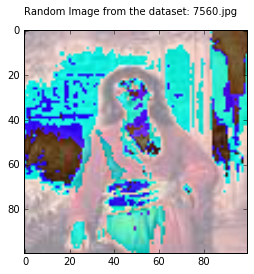

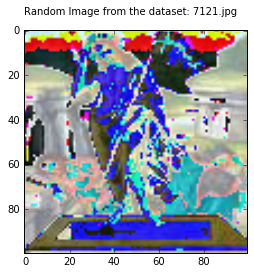

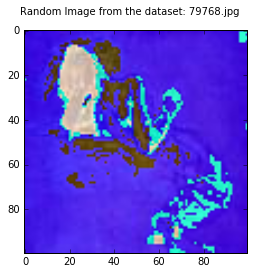

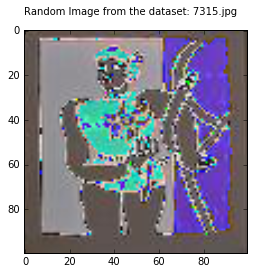

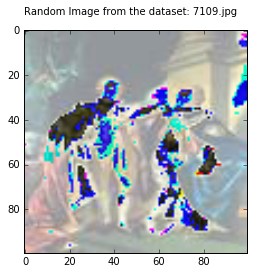

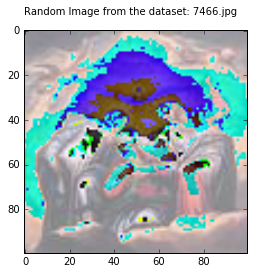

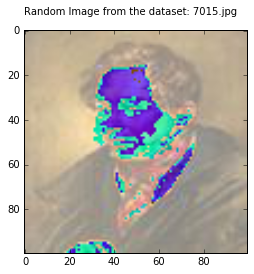

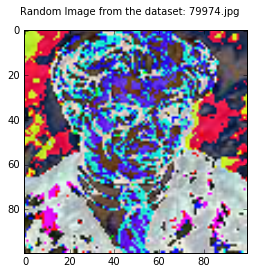

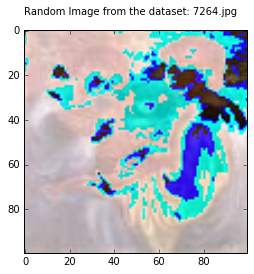

In [46]:
for i in range(1, 10):
    random_index = np.random.randint(train_dataset.shape[0])
    plt.figure().suptitle("Random Image from the dataset: %d.jpg" %(train_names[random_index]))
    plt.imshow(train_dataset[random_index])


In [27]:
def load_csv(path):
    train_labels = []
    with open(path, 'rb') as csvfile:
        num_labels = 0
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in spamreader:
            train_labels.append([row[0].split(".")[0], row[4]])
            num_labels += 1
    train_labels = train_labels[1:]
    return train_labels

In [28]:
data_labels = load_csv(csv_path)
print(len(train_labels))
data_labels[:20]

79433


[['102257', 'abstract'],
 ['75232', 'abstract'],
 ['29855', 'mythological painting'],
 ['62252', 'abstract'],
 ['63861', 'abstract'],
 ['53180', 'bird-and-flower painting'],
 ['70944', 'landscape'],
 ['59792', 'religious painting'],
 ['48138', 'landscape'],
 ['99442', 'marina'],
 ['23508', 'bird-and-flower painting'],
 ['82352', 'religious painting'],
 ['27254', 'bird-and-flower painting'],
 ['47145', 'bird-and-flower painting'],
 ['59145', 'abstract'],
 ['16876', 'religious painting'],
 ['28908', 'genre painting'],
 ['48177', 'still life'],
 ['7486', 'religious painting'],
 ['35766', 'religious painting']]

In [29]:
print(train_dataset.shape)
print(train_names.shape)
len(data_labels)

(259, 100, 100, 3)
(259,)


79433

In [30]:
def load_Labels(train_names, train_labels): # return the labels for the examples
    count = 0;
    labels = []
    for count in range(train_names.shape[0]):
        for label in train_labels:
            if(label[0] == str(train_names[count])):
                labels.append(label[1])
                break
        
        count += 1
        
        if(count % 1000 == 0):
            print("Working on Image no. %d" %count)
        
    return labels
    

## The following step requires some time. So, please wait

In [34]:
# filter the labels only that are required
train_labels = load_Labels(train_names, data_labels)
len(train_labels)

259

In [36]:
# check if the lables have been properly generated
(train_names[:20], train_labels[:20])

(array([ 7473,  7074,  7115,  7471, 79567,  7161,  7287,  7006,  7392,
         7481, 79875,   791,  7403,  7566, 79565,  7149, 79737, 79979,
         7252, 79665]),
 ['mythological painting',
  'portrait',
  'portrait',
  'portrait',
  'genre painting',
  'history painting',
  'genre painting',
  'illustration',
  'portrait',
  'portrait',
  'genre painting',
  'illustration',
  'genre painting',
  'religious painting',
  'portrait',
  'portrait',
  'genre painting',
  'portrait',
  'portrait',
  'religious painting'])

In [48]:
# filter the images that do not have a label
def filter_Non_Labelled(data, labels):
    index = 0
    while index < len(labels):
        if(labels[index] == ""):
            print("deleting %d th image" %index)
            data = np.delete(data, index, axis=0)
            labels.pop(index)
        
        else:
            index += 1
        
    return (data, labels)

In [51]:
train_dataset, train_labels = filter_Non_Labelled(train_dataset, train_labels)
(train_dataset.shape, len(train_labels))

((258, 100, 100, 3), 258)

In [52]:
# create a dictionary of mappings of labels to names
unique = sorted(list(set(train_labels)))
num_labels = len(unique)
label_mappings = {v: k for k, v in dict(enumerate(unique)).iteritems()}
label_mappings

{'allegorical painting': 0,
 'capriccio': 1,
 'caricature': 2,
 'design': 3,
 'figurative': 4,
 'genre painting': 5,
 'history painting': 6,
 'illustration': 7,
 'literary painting': 8,
 'mythological painting': 9,
 'nude painting (nu)': 10,
 'pastorale': 11,
 'portrait': 12,
 'poster': 13,
 'religious painting': 14,
 'self-portrait': 15,
 'sketch and study': 16,
 'still life': 17,
 'symbolic painting': 18,
 'yakusha-e': 19}

In [53]:
# function to hot encode the labels
def hot_encode(labels):
    encoded_labels = [[0 for i in range(0, len(label_mappings))] for j in range(0, len(train_labels))]
    for i in range(0, len(labels)):
        encoded_labels[i][label_mappings[labels[i]]] = 1
    return np.array(encoded_labels, dtype=np.float32)

In [56]:
encoded_train_labels = hot_encode(train_labels[:]) # pass by value

# check for the shapes of the input data:
(encoded_train_labels.shape, encoded_train_labels[0])

((258, 20),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))

In [59]:
''' For pickling the data acquired till now '''

# data dictionary


training_percentage = 70
cross_validation_percentage = 10
# remaining = test data

train_partition = (len(train_dataset) * training_percentage) / 100
cv_partition = (len(train_dataset) * (training_percentage + cross_validation_percentage)) / 100

data_dict = {
    "train_data" : train_dataset[: train_partition],
    "train_labels" : encoded_train_labels[: train_partition],
    "cv_data" : train_dataset[train_partition: cv_partition],
    "cv_labels" : encoded_train_labels[train_partition: cv_partition],
    "test_data" : train_dataset[cv_partition : ],
    "test_labels" : encoded_train_labels[cv_partition : ],
    
    "label_mapping" : label_mappings
}

if(not os.path.isfile(os.path.join(root, "PreData.pickle"))):
    with open(os.path.join(root, "PreData.pickle"), "wb") as pickle_file:
        pickle.dump(data_dict, pickle_file, pickle.HIGHEST_PROTOCOL)
        print("Pickling complete")
        
else:
    print("data is already pickled")

Pickling complete


## Finally, check if the data is properly pickled

In [60]:
with open(os.path.join(root, "PreData.pickle"), "rb") as pickle_file:
    my_dict = pickle.load(pickle_file)
    
len(my_dict)

7